# Build a training dataset for ML-based $\Delta$FAC from multiple SNOWPACK simulations
The training dataset needs columns of the following (where each row represents one example):
1. 365 day $\Delta$FAC (m)
2. 1980 - 2021 temperature climatology (C)
3. 0 - 365 day average temperature (C)
4. 1980 - 2021 precipitation climatology (mm/s)
5. 0 - 365 day average precipitation (mm/s)
6. Date sine
7. Date cosine

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import glob
from joblib import Parallel, delayed, memory
import xarray as xr

# Utility functions

In [2]:
def read_ratio(path):
    
    # Load .smet file as a Pandas data frame
    df = pd.read_csv(path)
    
    # Get ratio
    ratio_row = np.where(df[df.columns[0]].str.startswith("units_multiplier"))[0][0]
    ratio = float(df['SMET 1.1 ASCII'][ratio_row].split()[-2])
    if np.isnan(ratio):
        ratio = 1
        
    return ratio
    
def read_smet(path, var):

    """ Reads a .smet file and returns a time series of the defined variable as a pandas data frame.
    Args:
        path (str): String pointing to the location of the .smet file to be read.
        var  (str): Variable you want to plot
    Returns:
        Time series of defined variable as a pandas data frame.
    """

    # Load .smet file as a Pandas data frame
    df = pd.read_csv(path)
    
    # Get lat, lon, ratio
    lat_row = np.where(df[df.columns[0]].str.startswith("latitude"))[0][0]
    lon_row = np.where(df[df.columns[0]].str.startswith("longitude"))[0][0]
    
    lat = float(df['SMET 1.1 ASCII'][lat_row].split()[-1])
    lon = float(df['SMET 1.1 ASCII'][lon_row].split()[-1])

    # Determine indices for data retrieval
    bump = 2

    fields_row = np.where(df[df.columns[0]].str.startswith("fields"))[0][0] + bump
    data_row = np.where(df[df.columns[0]] == '[DATA]')[0][0] + bump
    fields =  np.loadtxt(path, skiprows=fields_row - 1, max_rows=1, dtype='str')
    data_col = []
    for k in range(0, len(var)):
        for j in range(0, len(list(fields[2:]))):
            if var[k] == fields[2+j]:
                data_col.append(j)

    # Creates pandas data frame
    time = np.loadtxt(path, skiprows=data_row, usecols=0, dtype = 'str')
    time = pd.to_datetime(time, format='%Y-%m-%dT%H:%M:%S')
    data = np.loadtxt(path, skiprows=data_row, usecols=tuple(data_col))
    df = pd.DataFrame(data, index=time)

    # Set no data values to nan
    df[df == -999] = np.nan

    # Return time series as daily average Pandas data frame
    return df, lat, lon

def calc_FAC(HS, SWE):
    
    """
    SNOWPACK assumes the density of ice is 917 kg/m^3
    """
    
    SWE_in_units_ice_equivalent = SWE / 0.917
    FAC = HS - SWE_in_units_ice_equivalent
    return FAC

def special_rolling_mean(df, n_min, n_max):
    special_mean = ((n_max * df.rolling(n_max).mean()) - (n_min * df.rolling(n_min).mean())) / (n_max - n_min)
    return special_mean

def calc_training_data(base_path, site):
    
    # File paths
    snowpack_smet = "/scratch/alpine/erke2265/mass-balance/" + base_path + "/output/" + site[:]+ ".smet"
    meteo_smet = "/scratch/alpine/erke2265/mass-balance/" +  base_path + "/smet/" + site.replace("_SPINUP", "", 1) + ".smet"
    
    # Meteo data
    snowpack_df, lat, lon = read_smet(snowpack_smet, ["HS_mod", "SWE"])
    ratio = read_ratio(meteo_smet)
    
    # Temperature
    M2_T2M = xr.open_mfdataset("M2_T2M_1980-2021.nc", combine='nested', concat_dim='time')
    ta_mean = M2_T2M.sel(lat=lat, lon=lon, method='nearest')['T2M'].mean(dim='time').values # Units: C
    ta_365_day_mean = M2_T2M.sel(lat=lat, lon=lon, method='nearest')['T2M'].rolling(time=365).mean().values # Units: C
    M2_T2M.close()

    # Precip
    M2_PSUM = xr.open_mfdataset("M2_PSUM_1980-2021.nc", combine='nested', concat_dim='time')
    psum_mean = M2_PSUM.sel(lat=lat, lon=lon, method='nearest')['__xarray_dataarray_variable__'].mean(dim='time').values # Units: mm/hr
    psum_90_day_mean = M2_PSUM.sel(lat=lat, lon=lon, method='nearest')['__xarray_dataarray_variable__'].rolling(time=90).mean().values # Units: mm/hr
    psum_365_day_mean = M2_PSUM.sel(lat=lat, lon=lon, method='nearest')['__xarray_dataarray_variable__'].rolling(time=365).mean().values # Units: mm/hr
    M2_PSUM.close()
    
    # Change in FAC
    HS = snowpack_df[0] / 100 # Units: m
    SWE = snowpack_df[1] / 1000 # Units: m

    HS = HS.resample('D').mean()
    SWE = SWE.resample('D').mean()

    FAC = calc_FAC(HS, SWE)
#     FAC = FAC.rolling(45).mean()
    delta_FAC_365_day = FAC.diff(periods=365) # Use in traning
    
    # Return data
    return ta_mean, ta_365_day_mean, psum_mean, psum_90_day_mean, psum_365_day_mean, delta_FAC_365_day, lat, lon, ratio


def save_site(base_path, site, index):
    
    # Initialize training array
    train = np.array([])
    
    # Sampling index (hacky... sorry)
    ind_1980 = 730 # 2 year
#     ind_1980 = 365 # 1 year
    
    # Get data
    ta_mean, ta_365_day_mean, psum_mean, psum_90_day_mean, psum_365_day_mean, delta_FAC_365_day, lat, lon, ratio = calc_training_data(base_path, site)


    # Get sin and cos of day of year (cyclic feature)
    doy = np.zeros(len(delta_FAC_365_day.index)); doy[:] = np.nan # day of year
    for k in range(0, len(delta_FAC_365_day.index)):
        doy[k] = delta_FAC_365_day.index[k].timetuple().tm_yday
    day_sin = np.sin(doy*(2.*np.pi/365))
    day_cos = np.cos(doy*(2.*np.pi/365))
    
    # Target data
    Y = np.squeeze(delta_FAC_365_day[ind_1980:].values)

    # Features
    RF_SMB_perturbation = np.repeat(ratio, len(Y))
    x1 = np.repeat(ta_mean, len(Y))
    x2 = np.squeeze(ta_365_day_mean[ind_1980:]) / x1
    x3 = np.repeat(psum_mean, len(Y)) * RF_SMB_perturbation
    x4 = np.squeeze(psum_90_day_mean[ind_1980:]) * RF_SMB_perturbation / x3
    x5 = np.squeeze(psum_90_day_mean[ind_1980-365:-365]) * RF_SMB_perturbation / x3
    x6 = np.squeeze(psum_365_day_mean[ind_1980:]) * RF_SMB_perturbation / x3
    x7 = day_sin[ind_1980:]
    x8 = day_cos[ind_1980:]

    # Combine features into readibly savable format
    lat_lon = np.array([[lat, lon]])
    train = np.transpose(np.stack([Y, x1, x2, x3, x4, x5, x6, x7, x8]))
    print(x4.shape)
    print(x5.shape)
    print(train.mean())
    print(train.shape)
    
    # Save array
    np.save(base_path + "_training_data/" + str(index) + "_train.npy", train)
    np.save(base_path + "_training_data/" + str(index) + "_lat_lon.npy", lat_lon)

# Loop over each site and save array of training data and lat/lon

In [3]:
!rm -r bin_sites_training_data
!rm -r 400_sites_training_data
!rm -r 100_sites_training_data
!mkdir -p bin_sites_training_data
!mkdir -p 400_sites_training_data
!mkdir -p 100_sites_training_data
base_snowpack_path = ["bin_sites", "400_sites", "100_sites"]

# # One site
# !cd /scratch/alpine/erke2265/mass-balance/bin_sites/output/; ls -- *.sno | wc -l; basename -s .sno -- *.sno > /scratch/alpine/erke2265/mass-balance/365_notebooks/finished.txt
# sites = np.loadtxt("finished.txt", dtype=str)
# save_site(base_snowpack_path[0], sites[0], 0) 

# All sites
for j in range(0, len(base_snowpack_path)):
    
    # Get training data from each SNOWPACK experiment
    print(base_snowpack_path[j])
    if j == 0:
        !cd /scratch/alpine/erke2265/mass-balance/bin_sites/output/; ls -- *.sno | wc -l; basename -s .sno -- *.sno > /scratch/alpine/erke2265/mass-balance/365_notebooks/finished.txt
        sites = np.loadtxt("finished.txt", dtype=str)
        Parallel(n_jobs=64)(delayed(save_site)(base_snowpack_path[j], sites[k], k) for k in range(0, len(sites)))

    elif j == 1:
        !cd /scratch/alpine/erke2265/mass-balance/400_sites/output/; ls -- *.sno | wc -l; basename -s .sno -- *.sno > /scratch/alpine/erke2265/mass-balance/365_notebooks/finished.txt
        sites = np.loadtxt("finished.txt", dtype=str)
        Parallel(n_jobs=64)(delayed(save_site)(base_snowpack_path[j], sites[k], k) for k in range(0, len(sites)))
    else:
        !cd /scratch/alpine/erke2265/mass-balance/100_sites/output/; ls -- *.sno | wc -l; basename -s .sno -- *.sno > /scratch/alpine/erke2265/mass-balance/365_notebooks/finished.txt
        sites = np.loadtxt("finished.txt", dtype=str)
        Parallel(n_jobs=64)(delayed(save_site)(base_snowpack_path[j], sites[k], k) for k in range(0, len(sites)))

bin_sites
380


/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


400_sites
396
100_sites
100


In [4]:
# filenames = glob.glob("*training_data/*train.npy")
# train = np.load(filenames[0]) 
# for j in range(0, train.shape[1]):
#     print(train[0, j])

# Make map

In [2]:
filenames = glob.glob("*training_data/*lat_lon.npy")
lat_lon = np.array([np.load(fname) for fname in filenames])
lat_lon = lat_lon.reshape(lat_lon.shape[1]*lat_lon.shape[0], lat_lon.shape[2])

(876, 2)


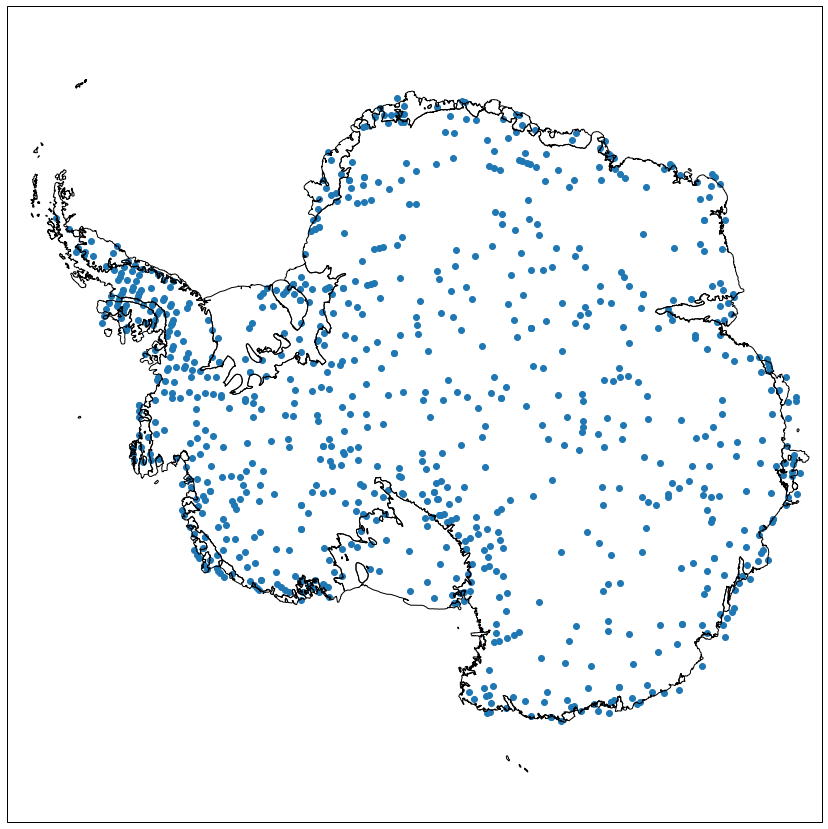

In [6]:
# Get coastlines
df = gpd.read_file("/pl/active/nasa_smb/Data/ADD_Coastline_low_res_polygon.shp")
crs_epsg = ccrs.SouthPolarStereo()
df_epsg = df.to_crs(epsg='3031')

# Generate figure 
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs_epsg},
                        figsize=(15, 15))

# Plot sites
plt.scatter(lat_lon[:,1], lat_lon[:,0], linewidth=1, transform=ccrs.PlateCarree())


# Plot coastlines
axs.set_extent((-180, 180, -90, -65), ccrs.PlateCarree())
axs.add_geometries(df_epsg['geometry'], crs=crs_epsg,
                      facecolor='none', edgecolor='black')
plt.savefig("figures/training_map.pdf", dpi=50)
print(lat_lon.shape)